In [1]:
# If running in a fresh environment you might need to install packages:
# !pip install transformers datasets scikit-learn torch tqdm

import os
import random
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AlbertTokenizerFast, AlbertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW   # <-- FIX: use PyTorch AdamW

from tqdm.auto import tqdm

print("torch:", torch.__version__)
import transformers
print("transformers:", transformers.__version__)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch: 2.7.1+cpu
transformers: 4.56.1


In [2]:
# ---------- Edit these paths / params as needed ----------
DATA_PATH = "../data/Updated_PHQ9_Student_Dataset.csv"  # path to your CSV
OUT_DIR = "models/phq9_albert_concat"
MODEL_NAME = "albert-base-v2"

RANDOM_SEED = 42
TEST_SIZE = 0.2

EPOCHS = 4
TRAIN_BATCH_SIZE = 8
EVAL_BATCH_SIZE = 16
LEARNING_RATE = 2e-5
MAX_LEN = 256   # increase if concatenated answers are long
WARMUP_PCT = 0.06

DELIMITER = " ||| "  # between answers when concatenating

os.makedirs(OUT_DIR, exist_ok=True)



In [3]:
# Dataset class and helper functions

class PHQ9ConcatDataset(Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

def find_question_columns(df):
    """
    Try several heuristics to locate 9 per-question text columns in the dataframe.
    Returns a list of column names in order if successful, else None.
    """
    cols = df.columns.tolist()
    # common short keys
    SHORT_Q_KEYS = [f"Q{i}" for i in range(1,10)] + [f"q{i}" for i in range(1,10)]
    found = [k for k in SHORT_Q_KEYS if k in cols]
    if len(found) == 9:
        return found

    # try exact question texts (common variants)
    POSSIBLE_Q_COLS = [
        "Little interest or pleasure in doing things?",
        "Feeling down, depressed, or hopeless?",
        "Trouble falling or staying asleep, or sleeping too much?",
        "Feeling tired or having little energy?",
        "Poor appetite or overeating?",
        "Feeling bad about yourself — or that you are a failure or have let yourself or your family down?",
        "Trouble concentrating on things, such as reading the newspaper or watching television?",
        "Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?",
        "Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?"
    ]
    found = [c for c in POSSIBLE_Q_COLS if c in cols]
    if len(found) == 9:
        return found

    # cleaned matching
    alt_keys = [c.replace(" ", "_").replace("—","-").replace("?","") for c in POSSIBLE_Q_COLS]
    found = []
    for alt in alt_keys:
        for c in cols:
            c_clean = c.replace(" ", "_").replace("—","-").replace("?","")
            if alt.lower() == c_clean.lower():
                found.append(c)
    if len(found) == 9:
        return found

    # keyword-based fallback in likely order
    keywords = ["interest", "down", "sleep", "tired", "appetite", "failure", "concentrat", "moving", "better off dead"]
    found = []
    for kw in keywords:
        for c in cols:
            if kw in c.lower():
                found.append(c)
                break
    if len(found) == 9:
        return found

    return None



In [4]:
# Load CSV
assert os.path.exists(DATA_PATH), f"Data file not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
print("Rows loaded:", len(df))
print("Columns:", df.columns.tolist()[:40])

qcols = find_question_columns(df)
if qcols is None:
    print("WARNING: Could not detect per-question text columns automatically.")
    print("Falling back to using 'PHQ-9 Total Score' as textual input (same as your earlier notebook).")
    fallback_col = "PHQ-9 Total Score"
    if fallback_col not in df.columns:
        raise RuntimeError(f"No per-question columns found and fallback '{fallback_col}' missing.")
    df["concat_text"] = df[fallback_col].astype(str)
else:
    print("Detected question columns (in order):")
    for i, c in enumerate(qcols, start=1):
        print(f" Q{i}: {c}")
    df[qcols] = df[qcols].fillna("").astype(str)
    df["concat_text"] = df[qcols].agg(DELIMITER.join, axis=1)

# Quick peek
df[["concat_text"]].head(3)


Rows loaded: 400
Columns: ['Age', 'Gender', 'Little interest or pleasure in doing things?', 'Feeling down, depressed, or hopeless?', 'Trouble falling or staying asleep, or sleeping too much?', 'Feeling tired or having little energy?', 'Poor appetite or overeating?', 'Feeling bad about yourself — or that you are a failure or have let yourself or your family down?', 'Trouble concentrating on things, such as reading the newspaper or watching television?', 'Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?', 'Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?', 'PHQ-9 Total Score', 'Depression Level']
Detected question columns (in order):
 Q1: Little interest or pleasure in doing things?
 Q2: Feeling down, depressed, or hopeless?
 Q3: Trouble falling or staying asleep, or sleeping too much?
 Q4: Feeling tired or having little energy?


,concat_text
0,Not at all ||| Several days ||| Not at all |||...
1,Several days ||| Nearly every day ||| More tha...
2,Nearly every day ||| Several days ||| Nearly e...


In [5]:
# Ensure target column present
assert "Depression Level" in df.columns, "Label column 'Depression Level' not found."

# Label encoding
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Depression Level"].astype(str))
label_map = {int(i): c for i, c in enumerate(label_encoder.classes_)}
print("Label mapping:", label_map)

# Train/val split (stratified)
X = df["concat_text"].astype(str).values
y = df["label"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_SEED)
print("Train / Val sizes:", len(X_train), len(X_val))


Label mapping: {0: 'Mild', 1: 'Minimal', 2: 'Moderate', 3: 'Moderately Severe', 4: 'Severe'}
Train / Val sizes: 320 80


In [6]:
# Tokenizer + encodings
tokenizer = AlbertTokenizerFast.from_pretrained(MODEL_NAME)
train_enc = tokenizer(list(X_train), truncation=True, padding=True, max_length=MAX_LEN)
val_enc = tokenizer(list(X_val), truncation=True, padding=True, max_length=MAX_LEN)

train_dataset = PHQ9ConcatDataset(train_enc, y_train)
val_dataset = PHQ9ConcatDataset(val_enc, y_val)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=EVAL_BATCH_SIZE)

print("Batches -> train:", len(train_loader), " val:", len(val_loader))


Batches -> train: 40  val: 5


In [7]:
# Model
num_labels = len(np.unique(y))
model = AlbertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_PCT * total_steps) if total_steps > 0 else 0
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss()


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu


In [8]:
best_val_loss = float("inf")
os.makedirs(OUT_DIR, exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    # Train
    model.train()
    train_losses = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} Train")
    for batch in pbar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
        pbar.set_postfix(train_loss=np.mean(train_losses))

    # Eval
    model.eval()
    val_losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            val_losses.append(loss.item())
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    avg_train_loss = np.mean(train_losses) if train_losses else 0.0
    avg_val_loss = np.mean(val_losses) if val_losses else 0.0
    val_acc = accuracy_score(all_labels, all_preds) if all_labels else 0.0

    print(f"Epoch {epoch}/{EPOCHS} -> train_loss: {avg_train_loss:.4f}  val_loss: {avg_val_loss:.4f}  val_acc: {val_acc:.4f}")

    # Save best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained(OUT_DIR)
        tokenizer.save_pretrained(OUT_DIR)
        with open(os.path.join(OUT_DIR, "label_map.pkl"), "wb") as f:
            pickle.dump(label_map, f)
        print("Saved best model to", OUT_DIR)

print("Training complete. Best val_loss:", best_val_loss)


Epoch 1 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 Val: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Epoch 1/4 -> train_loss: 1.2603  val_loss: 1.1277  val_acc: 0.4625
Saved best model to models/phq9_albert_concat


Epoch 2 Val: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 2/4 -> train_loss: 0.9563  val_loss: 0.7292  val_acc: 0.7750
Saved best model to models/phq9_albert_concat


Epoch 3 Val: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 3/4 -> train_loss: 0.5956  val_loss: 0.5115  val_acc: 0.8500
Saved best model to models/phq9_albert_concat


Epoch 4 Val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]

Epoch 4/4 -> train_loss: 0.4571  val_loss: 0.4618  val_acc: 0.8875
Saved best model to models/phq9_albert_concat
Training complete. Best val_loss: 0.46181249618530273


Final Eval (full): 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]

Accuracy: 0.8875

True label distribution (label_idx:count): {0: 9, 2: 34, 3: 33, 4: 4}
Predicted label distribution (label_idx:count): {0: 7, 2: 39, 3: 34}

Classification report (all labels):

                   precision    recall  f1-score   support

             Mild       1.00      0.78      0.88         9
          Minimal       0.00      0.00      0.00         0
         Moderate       0.87      1.00      0.93        34
Moderately Severe       0.88      0.91      0.90        33
           Severe       0.00      0.00      0.00         4

         accuracy                           0.89        80
        macro avg       0.55      0.54      0.54        80
     weighted avg       0.85      0.89      0.86        80



,Mild,Minimal,Moderate,Moderately Severe,Severe
Mild,7,0,2,0,0
Minimal,0,0,0,0,0
Moderate,0,0,34,0,0
Moderately Severe,0,0,3,30,0
Severe,0,0,0,4,0


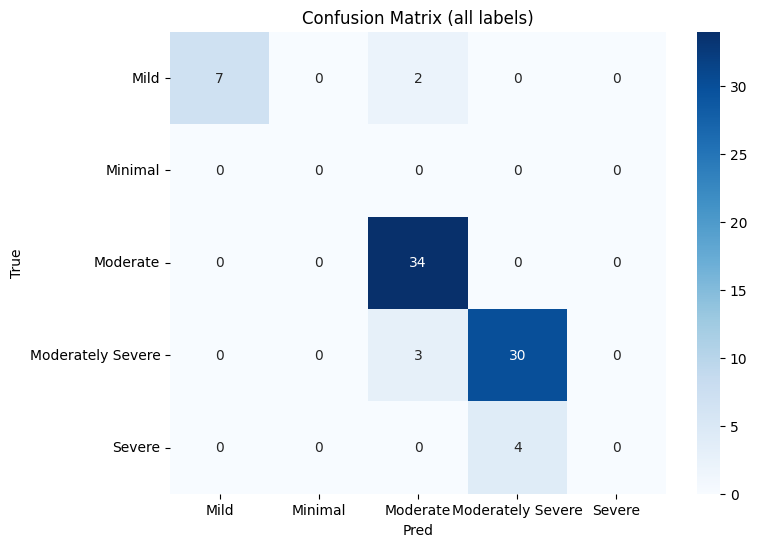

In [10]:
# Option B: full report for all label classes (shows zero metrics for missing predictions)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Eval (full)"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Accuracy:", accuracy_score(all_labels, all_preds))
print()

# Show support
unique, counts = np.unique(all_labels, return_counts=True)
print("True label distribution (label_idx:count):", dict(zip(unique.tolist(), counts.tolist())))
unique_p, counts_p = np.unique(all_preds, return_counts=True)
print("Predicted label distribution (label_idx:count):", dict(zip(unique_p.tolist(), counts_p.tolist())))
print()

n_classes = len(label_encoder.classes_)
labels_full = list(range(n_classes))
target_names_full = list(label_encoder.classes_)

print("Classification report (all labels):\n")
print(classification_report(all_labels, all_preds,
                            labels=labels_full,
                            target_names=target_names_full,
                            zero_division=0))

# Confusion matrix for all labels
cm = confusion_matrix(all_labels, all_preds, labels=labels_full)
cm_df = pd.DataFrame(cm, index=target_names_full, columns=target_names_full)
display(cm_df)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (all labels)")
plt.ylabel("True")
plt.xlabel("Pred")
plt.show()


In [1]:
import os
import pickle
import torch
import numpy as np
from transformers import AlbertTokenizerFast, AlbertForSequenceClassification

# === Load model and tokenizer ===
MODEL_DIR = "models/phq9_albert_concat"   # adjust if saved elsewhere
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AlbertTokenizerFast.from_pretrained(MODEL_DIR, local_files_only=True)
model = AlbertForSequenceClassification.from_pretrained(MODEL_DIR, local_files_only=True)
model.to(DEVICE)
model.eval()

# load label_map
label_map_path = os.path.join(MODEL_DIR, "label_map.pkl")
with open(label_map_path, "rb") as f:
    label_map = pickle.load(f)

# === Hard-coded example answers (Q1..Q9) ===
answers = [
    "I rarely enjoy doing things these days.",                    # Q1
    "I feel down and hopeless most of the time.",                 # Q2
    "I have trouble sleeping almost every night.",                # Q3
    "I feel tired nearly every day.",                             # Q4
    "I overeat when I’m stressed.",                               # Q5
    "I often feel like I’ve let my family down.",                 # Q6
    "It’s hard to concentrate on reading or watching TV.",         # Q7
    "People notice I move more slowly than before.",              # Q8
    "Sometimes I think I’d be better off dead."                   # Q9
]

# concatenate into one string (must match training format)
concat_text = " ||| ".join(answers)

# === Run through model ===
enc = tokenizer(concat_text, truncation=True, padding="max_length", max_length=256, return_tensors="pt")
input_ids = enc["input_ids"].to(DEVICE)
attention_mask = enc["attention_mask"].to(DEVICE)

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits.cpu().numpy()[0]
    probs = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()

pred_idx = int(np.argmax(probs))
pred_label = label_map.get(pred_idx, pred_idx)

print("Predicted class index:", pred_idx)
print("Predicted label:", pred_label)
print("Class probabilities:", {label_map[i]: float(p) for i, p in enumerate(probs)})


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Predicted class index: 3
Predicted label: Moderately Severe
Class probabilities: {'Mild': 0.055345457047224045, 'Minimal': 0.025188010185956955, 'Moderate': 0.3162563145160675, 'Moderately Severe': 0.5387077927589417, 'Severe': 0.06450243294239044}
